In [1]:
!pip install gpytorch
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install river

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
import numpy as np
import pandas as pd

import pickle

import gymnasium as gym
from gymnasium.wrappers import TransformReward, TransformObservation

from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import scipy
from scipy.stats import norm
from scipy.special import logsumexp

import torch
from torch.optim.lr_scheduler import ExponentialLR
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

from huggingface_sb3 import load_from_hub
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

from collections import deque
from typing import Tuple

from time import sleep

from river import drift

## SAC Pendulum

In [5]:
checkpoint = load_from_hub(
    repo_id = "sb3/sac-Pendulum-v1",
    filename = "sac-Pendulum-v1.zip",
)

model = SAC.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


## Create Environment

In [7]:
env0 = gym.make("Pendulum-v1", g=10.0) # Training Environment
env1 = gym.make("Pendulum-v1", g=10.0) # Undrifted Production Environment
env2 = gym.make("Pendulum-v1", g=10.5) # Drifted Production Environment

## Training SVGP Action Predictor in Training Environment

In [8]:
observations = []
actions = []
transitions = []
rewards = []
dones = []

obs_t, _ = env0.reset()
observations.append(obs_t)

for i in range(20000):
  action_t, _state = model.predict(obs_t, deterministic=True)
  actions.append(action_t)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)

  done = terminated or truncated
  dones.append(done)

  observations.append(obs_tplus1)
  transitions.append(np.concatenate([obs_t, obs_tplus1-obs_t]))
  rewards.append(r_tplus1)

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env0.reset()

transitions_env0 = np.array(transitions)
actions_env0 = np.array(actions)

n_train = int(len(transitions_env0)*0.8)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
X_train_env0, X_test_env0, y_train_env0, y_test_env0 = transitions_env0[:n_train],transitions_env0[n_train:],\
      actions_env0[:n_train],  actions_env0[n_train:]


scaler = StandardScaler()
scaler.fit(X_train_env0)
X_train_env0_scaled = scaler.transform(X_train_env0)
X_test_env0_scaled = scaler.transform(X_test_env0)


# Compute inducing points
n_inducing = 100
kmeans = KMeans(n_clusters=n_inducing).fit(X_train_env0_scaled)
inducing_points = kmeans.cluster_centers_
inducing_points = torch.from_numpy(inducing_points.astype(np.float32)).to(device)


X_train_env0_tensor = torch.from_numpy(X_train_env0_scaled).contiguous()
X_test_env0_tensor = torch.from_numpy(X_test_env0_scaled).contiguous()
y_train_env0_tensor = torch.from_numpy(y_train_env0).reshape(-1).contiguous()
y_test_env0_tensor = torch.from_numpy(y_test_env0).reshape(-1).contiguous()


class ActionPredictor(ApproximateGP):
  def __init__(self, inducing_points):
    variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
    variational_strategy = VariationalStrategy(self, inducing_points,
                                               variational_distribution,
                                               learn_inducing_locations=True)
    super(ActionPredictor, self).__init__(variational_strategy)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=X_train_env0_tensor.size(-1)))

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model_gp_env0 = ActionPredictor(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model_gp_env0 = model_gp_env0.to(device)
likelihood = likelihood.to(device)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_env0_tensor, y_train_env0_tensor)
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True)
test_dataset = TensorDataset(X_test_env0_tensor, y_test_env0_tensor)
test_loader = DataLoader(test_dataset, batch_size=800, shuffle=False)

In [13]:
# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [14]:
num_epochs = 3000

model_gp_env0.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {"params": model_gp_env0.parameters()},
    {"params": likelihood.parameters()},
], lr=0.05)
scheduler = ExponentialLR(optimizer, gamma=1-1e-3)


# loss object: VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model_gp_env0,
                                    num_data=y_train_env0_tensor.size(0))


best_loss_test = np.inf
losses_train = []
losses_test = []


for i in range(num_epochs):
  # Within each iteration, we will go over each minibatch of data
  model_gp_env0.train()
  likelihood.train()
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    optimizer.zero_grad()
    output = model_gp_env0(x_batch)
    loss = -mll(output, y_batch)
    loss.backward()
    optimizer.step()
    losses_train.append(loss.item())

  with torch.no_grad():
    model_gp_env0.eval()
    likelihood.eval()
    for x_batch, y_batch in test_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      output = model_gp_env0(x_batch)
      loss = -mll(output, y_batch)
      losses_test.append(loss.item())

  print(f"Epoch: {i+1}, train loss: {np.mean(losses_train)}, test loss: {np.mean(losses_test)}")

  if np.mean(losses_test) < best_loss_test:
      torch.save(model_gp_env0, "model_gp_env0.pth")
      best_loss_test = np.mean(losses_test)
      print("Best model so far.")

Epoch: 1, train loss: 1.087976524233818, test loss: 0.8296033263206481
Best model so far.
Epoch: 2, train loss: 0.8146949060261249, test loss: 0.5378059446811676
Best model so far.
Epoch: 3, train loss: 0.5328844279361268, test loss: 0.25276407798131306
Best model so far.
Epoch: 4, train loss: 0.24894817846361547, test loss: -0.03119145929813385
Best model so far.
Epoch: 5, train loss: -0.015806540828198195, test loss: -0.27841238260269163
Best model so far.
Epoch: 6, train loss: -0.2457052334987869, test loss: -0.47641716996828715
Best model so far.
Epoch: 7, train loss: -0.4417081079179687, test loss: -0.653433975151607
Best model so far.
Epoch: 8, train loss: -0.600140013161581, test loss: -0.8008700683712959
Best model so far.
Epoch: 9, train loss: -0.7501811481080949, test loss: -0.9350801825523376
Best model so far.
Epoch: 10, train loss: -0.8514770802762359, test loss: -1.030934408903122
Best model so far.
Epoch: 11, train loss: -0.9674140266312117, test loss: -1.144750745729966

## Environment Drift Detection

In [15]:
class ActionPredictor(ApproximateGP):
  def __init__(self, inducing_points):
    variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
    variational_strategy = VariationalStrategy(self, inducing_points,
                                               variational_distribution,
                                               learn_inducing_locations=True)
    super(ActionPredictor, self).__init__(variational_strategy)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=X_train_env0_tensor.size(-1)))

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Load Trained SVGP ActionPredictor
model_gp_env0 = torch.load("model_gp_env0.pth")

with open("scaler.pkl", 'rb') as f:
  scaler = pickle.load(f)

In [20]:
with torch.no_grad():

  env1_step = 3000
  env2_step = 3000


  total_step = env1_step + env2_step


  n_past_steps_to_store = 500
  replay_buffer = deque([], maxlen=n_past_steps_to_store)

  mses_production = []

  env1 = gym.make("Pendulum-v1", g=10.0) # Same as the original env
  env2 = gym.make("Pendulum-v1", g=10.5) # Drifted Environment with different gravity

  env_current = env1
  obs_t, _ = env_current.reset() # Initialize the environment

  for t in range(1, total_step+1):

    if t%500 == 0:
      print(f"step {t}")

    action_t, _state = model.predict(obs_t, deterministic=True)
    action_t_tensor = torch.from_numpy(action_t)
    obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)
    replay_buffer.append([obs_t, action_t, obs_tplus1, r_tplus1, t])
    x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
    x = scaler.transform(x)
    x = torch.from_numpy(x)
    predict_t = model_gp_env0(x)
    mses_production.append(mse(predict_t.mean.detach().cpu().numpy(),
                    action_t_tensor.numpy()))




    done = terminated or truncated

    obs_t = obs_tplus1

    if done:
      obs_t, _ = env_current.reset()

    if t==env1_step: ## Environment Drift Happens
      env_current = env2
      obs_t, _ = env_current.reset()

step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


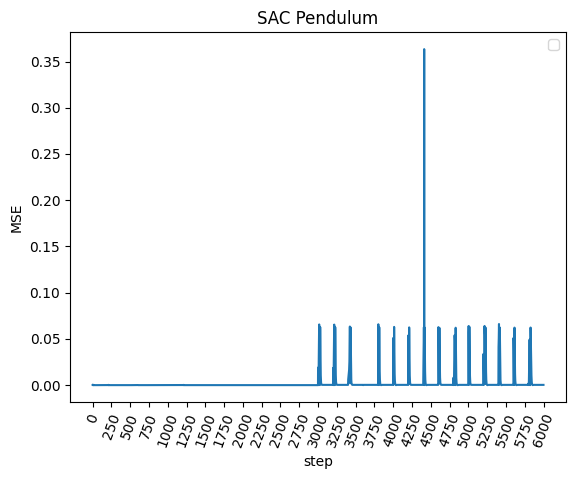

In [21]:
plt.plot(np.array(mses_production))
#plt.axvline(x=3000, label="Environment Drift", color='red')
plt.xticks(np.arange(0,6001,250), rotation=70)
plt.xlabel("step")
plt.ylabel("MSE")
plt.legend()
plt.title("SAC Pendulum")
plt.show()

### Environment Drift Detection with CUSUM

In [22]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [23]:
# Environment Drift Detection with CUSUM
env0_steps = 4000
window_size = 200
mses_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

#print(f"Reference mean: {np.mean(mses_reference)}, Reference std: {np.std(mses_reference)}")

mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)
mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref = sigma_ref,
                                   obs_ref=mses_reference_window,
                                   p_limit = p_limit)

false_alarms = 0
delay = 4000

for i,val in enumerate(mses_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="greater")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()
    drift_detector._reset(mses_reference_window)
    if i < 3000:
      false_alarms += 1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Drift Detected at: 2 with value: 1.3951604159956332e-05
Drift Detected at: 12 with value: 0.000168464524904266
Drift Detected at: 13 with value: 0.0003128455427940935
Drift Detected at: 14 with value: 9.346777369501069e-05
Drift Detected at: 3000 with value: 0.018939388915896416
False Alarms: 4, Delay: 0


### Page-Hinkley

In [24]:
ph = drift.PageHinkley(mode="up", delta=0.005)

env0_steps = 4000
mses_reference = []
p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  ph.update(val)
  if ph.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 3000, input value: 1683.639404296875
False Alarms: 0, Delay: 0


### ADWIN

In [25]:
adwin = drift.ADWIN()

env0_steps = 4000
mses_reference = []
p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break


print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 3039, input value: 1.2310898303985596
False Alarms: 0, Delay: 39


### KSWIN

In [26]:
kswin = drift.KSWIN()

env0_steps = 4000
mses_reference = []
p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break


print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 215, input value: 0.26002705097198486
Change detected at index 415, input value: 3.5657613277435303
Change detected at index 1227, input value: 0.10194982588291168
Change detected at index 2010, input value: 3.822038173675537
Change detected at index 2415, input value: 7.936280250549316
Change detected at index 2618, input value: 1.793910264968872
Change detected at index 2819, input value: 1.1098641157150269
Change detected at index 3019, input value: 5827.52099609375
False Alarms: 7, Delay: 19
